In [1]:
#%pip install -U pretty_midi

In [2]:
#%pip install -U pretty_midi
#%pip install matplotlib
#%pip install seaborn
import pretty_midi
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-07-14 23:25:09.804680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_dir = "Four_composers"

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [4]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    total_velocity = 0
    total_notes = 0
    for instrument in midi_data.instruments:
        total_velocity += sum(note.velocity for note in instrument.notes)
        total_notes += len(instrument.notes)
    
    avg_velocity = total_velocity / total_notes if total_notes > 0 else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    return [tempo, num_instruments, avg_velocity, key] + pitch_classes

X = []
y = []
error_count = 0
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")

Error parsing MIDI file Four_composers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipping file Four_composers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid due to errors
Error parsing MIDI file Four_composers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Skipping file Four_composers/Beethoven/Anhang 14-3.mid due to errors


### Convert X into an array. Perform train-test split.

In [6]:
X_np = np.array(X)
y_np = np.array(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

### Standard Scaling on X_train and X_test.

In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SMOTE resampling on the training sets

In [9]:
#%pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Visualize the data imbalance, and correction after SMOTE.

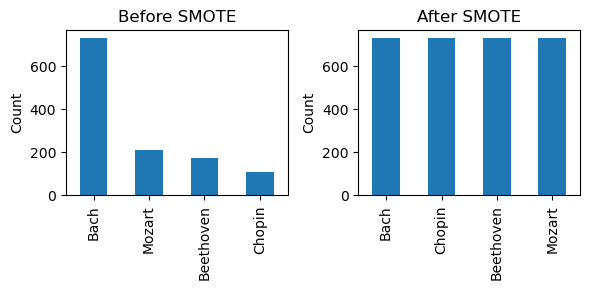

In [10]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

### SVM

In [ ]:
# # Train a Support Vector Machine classifier
# svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
# svm_clf.fit(X_train_scaled_smote, y_train_smote)

### Train model using radial basis vector kernel.

In [ ]:
# y_pred = svm_clf.predict(X_test_scaled)
# rbf_accuracy = accuracy_score(y_test, y_pred)
# rbf_f1 = f1_score(y_test, y_pred, average='weighted')
# print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
# print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

In [ ]:
# # Generate and print the classification report
# report = classification_report(y_test, y_pred, zero_division=1)
# print("Classification Report:")
# print(report)

### Print confusion matrix.

In [ ]:
# labels = sorted(set(y_test) | set(y_pred))

# cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
# fontsize = 7
# figsize = (7, 6)  # Increased figure size for better readability
# cmap = plt.colormaps.get_cmap("Blues")
# fig, ax = plt.subplots(figsize=figsize)

# sns.heatmap(cmatrix, 
#             annot=True, 
#             cmap=cmap, 
#             cbar=True, 
#             ax=ax, 
#             linewidths=0.5,
#             fmt='d',
#             annot_kws={'fontsize': 14},
#             xticklabels=labels,
#             yticklabels=labels)

# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('Actual', fontsize=12)
# plt.title('Confusion Matrix', fontsize=14)

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

# plt.tight_layout()
# plt.show()

In [11]:
X_train_scaled_smote.shape

(2924, 16)

In [12]:
X_test_scaled.shape

(306, 16)

### LSTM

#### Reshape X train and X test

In [13]:
num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

In [14]:
X_train_reshaped.shape

(2924, 16, 1)

In [15]:
X_test_reshaped.shape

(306, 16, 1)

In [17]:
print(input_shape)

(16, 1)


#### Encode target variable

In [16]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_train_encoded = LE.fit_transform(y_train_smote)
y_test_encoded = LE.transform(y_test)

from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

#### Build and train model

In [18]:
lstm_model = Sequential([
    # First convolutional block
    LSTM(16),
    
    # Dense layers
    Dense(128, activation="sigmoid"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation="sigmoid"),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='tanh')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test_categorical)
print(f'Test Accuracy: {accuracy}')

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
result = lstm_model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_test_reshaped, y_test_categorical), epochs=100,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping])

2024-07-14 23:30:01.954773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 [==============================] - 1s 2ms/step - loss: 11.5882 - accuracy: 0.6340
Test Accuracy: 0.6339869499206543
Epoch 1/100
92/92 [==============================] - 2s 7ms/step - loss: 5.2676 - accuracy: 0.2938 - val_loss: 11.6068 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 0s 5ms/step - loss: 3.0766 - accuracy: 0.2873 - val_loss: 10.7045 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 0s 5ms/step - loss: 2.3162 - accuracy: 0.2603 - val_loss: 4.2972 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 0s 5ms/step - loss: 2.0033 - accuracy: 0.2674 - val_loss: 1.8579 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 1.6891 - accuracy: 0.2510 - val_loss: 1.6007 - val_accuracy: 0.1928 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - 1s 7ms/step - loss: 1.6734 - accuracy: 0.2507 - val_l

#### Evaluate training

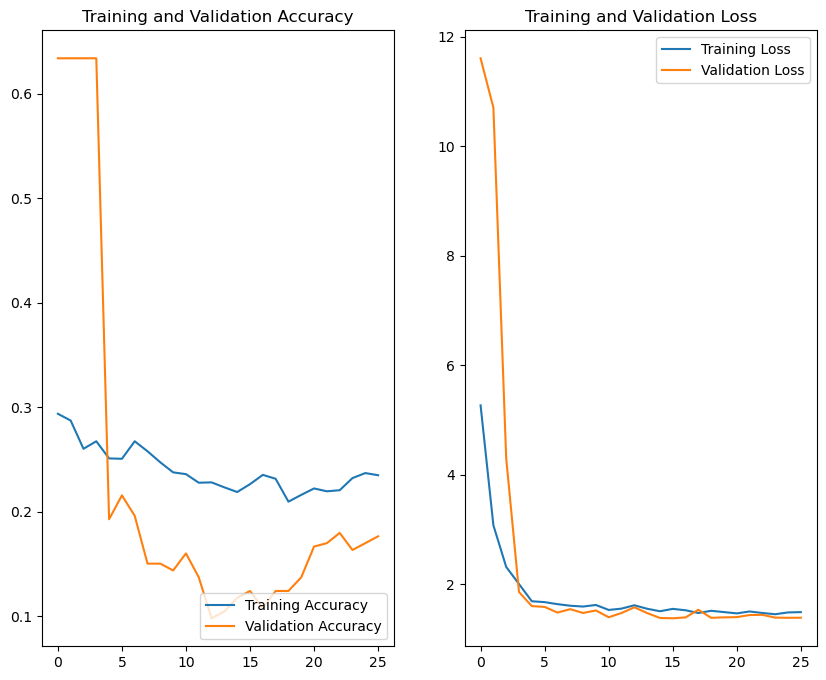

In [19]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Make predictions

In [21]:
y_pred = lstm_model.predict(X_test_reshaped)

10/10 [==============================] - 0s 2ms/step


In [22]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.33      0.12      0.18       194
           1       0.50      0.08      0.13        39
           2       0.08      0.12      0.10        26
           3       0.04      0.17      0.07        47

    accuracy                           0.12       306
   macro avg       0.24      0.12      0.12       306
weighted avg       0.29      0.12      0.15       306



### CNN

#### Reshape X train and X test

In [ ]:
num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

#### Encode target variable (composer label)

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_train_encoded = LE.fit_transform(y_train_smote)
y_test_encoded = LE.transform(y_test)

from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

#### Build model and train

In [18]:
cnn_model = Sequential([
    # Input normalization
    BatchNormalization(input_shape=input_shape),
    
    # First convolutional block
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Third convolutional block
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),
    
    # Dense layers
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

loss, accuracy = cnn_model.evaluate(X_test_reshaped, y_test_categorical)
print(f'Test Accuracy: {accuracy}')

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
result = cnn_model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_test_reshaped, y_test_categorical), epochs=100,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping])

2024-07-14 21:16:55.911972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 [==============================] - 1s 3ms/step - loss: 1.3947 - accuracy: 0.1732
Test Accuracy: 0.17320261895656586
Epoch 1/100
93/93 [==============================] - 3s 11ms/step - loss: 1.7357 - accuracy: 0.4128 - val_loss: 0.9313 - val_accuracy: 0.6601 - lr: 0.0010
Epoch 2/100
93/93 [==============================] - 1s 11ms/step - loss: 1.3477 - accuracy: 0.5176 - val_loss: 0.8664 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/100
93/93 [==============================] - 1s 11ms/step - loss: 1.1555 - accuracy: 0.5645 - val_loss: 0.8018 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 4/100
93/93 [==============================] - 1s 11ms/step - loss: 1.0168 - accuracy: 0.5970 - val_loss: 0.7717 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 5/100
93/93 [==============================] - 1s 11ms/step - loss: 0.9587 - accuracy: 0.6274 - val_loss: 0.7676 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 6/100
93/93 [==============================] - 1s 10ms/step - loss: 0.8645 - accuracy: 0.6449 - v

#### Evaluate training

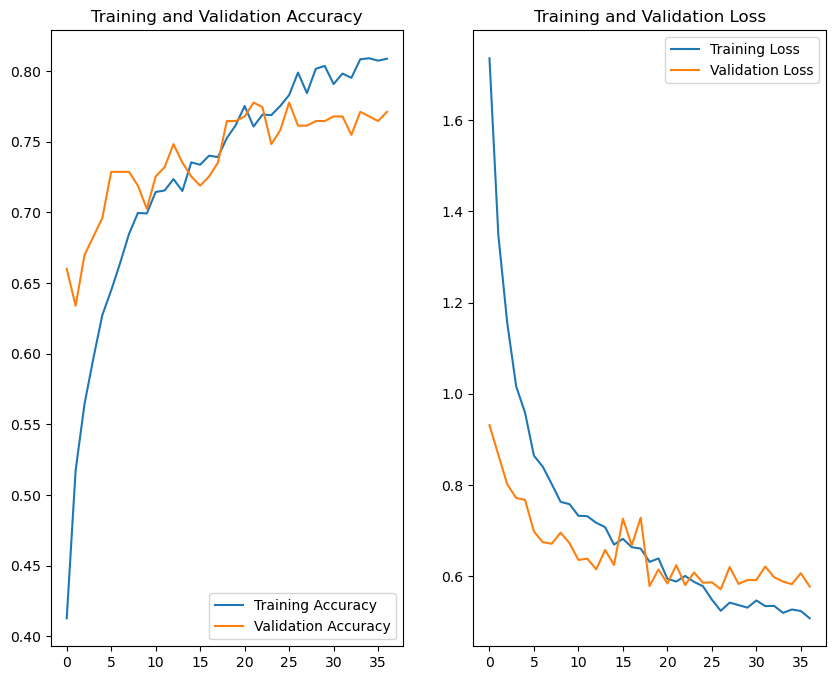

In [19]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Make predictions

In [20]:
y_pred = cnn_model.predict(X_test_reshaped)

10/10 [==============================] - 0s 3ms/step


In [21]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       185
           1       0.50      0.49      0.49        39
           2       0.57      0.86      0.68        29
           3       0.58      0.68      0.63        53

    accuracy                           0.76       306
   macro avg       0.65      0.71      0.67       306
weighted avg       0.79      0.76      0.77       306

